# RNN(循环神经网络)

潜变量自回归模型
- 使用潜在变量ht去总结过去信息

循环神经网络
- 更新隐藏状态
- 输出

困惑度(perplexity)
- 衡量一个语言模型的好坏可以使用平均交叉熵
p是语言模型的预测概率，xt是真实词
- 历史原因NLP使用困惑度exp(pi)来衡量，是平均每次可能的选项
  - 1表示完美，无穷大是最差的情况

梯度剪裁
- 迭代中计算这T个时间步上的梯度，在反向传播过程中产生长度为O(T)的矩阵乘法链，导致数值不稳定
- 梯度裁剪可以有效预防梯度爆炸
  - 如果梯度长度超过theta，那么拖影长度回长度theta

总结
- 循环神经网络的输出取决于当下输入和前一时间的隐变量
- 应用到语言模型时，循环神经网络根据当前词预测下一时刻词
- 通常使用困惑度来衡量语言模型的好坏

In [1]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
#创建正态分布的tensor张量
X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))

In [3]:
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[-0.5723, -0.5102,  1.4208, -1.1566],
        [ 2.0137,  1.2535,  0.3890, -1.2259],
        [-1.4801, -2.8364,  3.6511,  3.8597]])

In [4]:
#沿列(axis=1)拼接矩阵X和H，沿行(axis=0)拼接矩阵W_xh和W_hh
#两个拼接分别产生形状(3, 5)和形状(5, 4)的矩阵
#再将这两个拼接的矩阵相乘，得到上述相同的输出矩阵
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[-0.5723, -0.5102,  1.4208, -1.1566],
        [ 2.0137,  1.2535,  0.3890, -1.2259],
        [-1.4801, -2.8364,  3.6511,  3.8597]])

In [5]:
#独热编码
#将每个索引映射为相互不同的单位向量
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [6]:
#每次采样的小批量的数据形状是二维张量(batch_size, num_steps),
# one_hot函数将小批量数据转换为三维张量
X = torch.arange(10).reshape((2, 5))
#长度为28，包含开始，26个字母以及结尾词
F.one_hot(X.T, 28).shape 

torch.Size([5, 2, 28])

In [7]:
#初始化模型参数
def get_params(vocab_size, num_hiddens, device):
    """初始化模型参数"""
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        """正态分布"""
        return torch.randn(size= shape, device= device) * 0.01
    #隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device= device)
    #输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device= device)
    #给参数附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        #执行原地操作
        param.requires_grad_(True)
    #返回模型参数
    return params

In [8]:
#初始化模型时返回隐藏状态
def init_rnn_state(batch_size, num_hiddens, device):
    #形状为(批量大小，隐藏单元个数)
    return (torch.zeros((batch_size, num_hiddens), device= device), )

In [9]:
#在一个时间步内计算隐藏状态和输出
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim= 0), (H,)

In [10]:
#创建一个RNNScratch类来封装函数
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [11]:
#检查输出是否是正确的形状
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, 
                     init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [12]:
#生成prefix之后的新字符，prefix是一个用户提供的包含多个字符的字符串
#将隐状态传递到下一个时间步，但是不生成任何输出。 这被称为预热（warm-up）期
#预热期结束后，执行预测
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在prefix后生成新的字符"""
    state = net.begin_state(batch_size=1, device= device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device= device).reshape((1, 1))
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        #预测num_preds步长的字符
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim= 1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [13]:
#执行预测
predict_ch8('time traveller', 10, net, vocab, d2l.try_gpu())

'time travellerhxpqrhxpqr'

In [14]:
#进行梯度裁剪
def grad_clipping(net, theta):
    """裁剪梯度"""
    #先判断网络类别，如果是nn.Module类，直接从parameters方法中获取梯度
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad** 2))for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [15]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络的一个迭代周期"""
    state, timer = None, d2l.Timer()
    #训练损失之和
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        #判断隐藏状态为空或使用随机迭代
        if state is None or use_random_iter:
            state = net.begin_state(batch_size= X.shape[0], device= device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        #判断更新是否使用torch.optim.Optimizer方法类
        if isinstance(updater, torch.optim.Optimizer):
            #清空梯度
            updater.zero_grad()
            l.backward()
            #执行梯度裁剪
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            #迭代
            updater(batch_size= 1)
        metric.add(l * y.numel(), y.numel())
    #返回模型困惑度和训练速度
    return math.exp(metric[0]/ metric[1]), metric[1] / timer.stop()

In [16]:
#训练函数支持从0实现的RNN模型以及使用API实现
def train_ch8(net, train_iter, vocab, lr, num_epochs, 
              device, use_random_iter= False):
    """训练模型"""
    #损失函数：交叉熵损失函数
    loss = nn.CrossEntropyLoss()
    #动态绘制训练曲线
    animator = d2l.Animator(xlabel= 'epoch', ylabel= 'perplexity', legend= ['train'], 
                            xlim= [10, num_epochs])
    #初始化
    #使用API实现
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        #自定义实现
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    #执行训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        #每十次训练进行记录
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch+1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.2, 100722.7 词元/秒 cuda:0
time traveller for so it will in tu ne thengwsuch which is a lix
traveller curc ianthat in the giom vescenor wip sime sion o


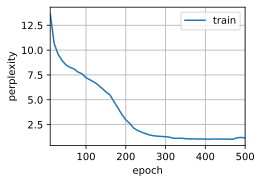

In [17]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.6, 114176.1 词元/秒 cuda:0
time traveller hald have to controvert one or twoideas that are 
travellerit s against reason said filbycho ngather had a do


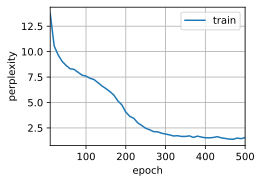

In [18]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, 
                      init_rnn_state, rnn)
#使用随机迭代方式
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), use_random_iter= True)

## 循环神经网络的简洁实现

In [19]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [20]:
num_hiddens = 256
#使用API定义RNN模型
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [21]:
#使用张量来初始化隐藏状态
#形状：(隐藏层数，批量大小，隐藏单元数)
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [22]:
#通过一个隐藏状态和一个输入，得到更新后的隐状态输出
X = torch.rand(size= (num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [23]:
#定义RNNModel类
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        #如果RNN为双向，num_directions应该是2，反之为1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens* 2, self.vocab_size)
    
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        #返回输出和隐藏状态
        return output, state
    
    def begin_state(self, device, batch_size= 1):
        if not isinstance(self.rnn, nn.LSTM):
            #GRU以张量作为隐藏状态
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens),
                                device= device)
        else:
            #nn.LSTM以元组作为隐藏状态
            return (torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), 
                    device= device),
                    torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), 
                    device= device))

In [25]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size= len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerkkmkmpykmr'

困惑度 1.3, 608697.2 词元/秒 cuda:0
time traveller proceeded the dimentions on spreent one mothrrewi
travellerit s agait tray io mevery all raveredouner wor ano


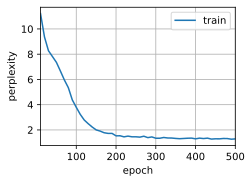

In [26]:
#训练模型
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)